In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})
from pathlib import Path
from itertools import count
from PIL import Image
import torch
import vgg_face.models.resnet as ResNet
import cv2
import json

import torch, torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    device = torch.device('cuda')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Not using GPU")
    
from torch.utils.data import Dataset

MASK = np.array(Image.open('eyeglasses_mask_6percent.png'))
FR_NET = ResNet.resnet50(num_classes=20, include_top=True)
FR_NET.load_state_dict(torch.load('vgg_face/finetuned.pth'))
FR_NET.to(device)
MEAN_BGR = np.array([91.4953, 103.8827, 131.0912]) 
FR_NET.eval()

CODE_SIZE = 25

IMG_SHAPE = (3, 64, 176)


Torch version: 1.0.1.post2
Using GPU


In [2]:
class GlassesDataset(Dataset):
    def __init__(self, path, transform=None):
        self.data = []
        self.transform = transform
        for img_path in Path(path).iterdir():
            if img_path.suffix[1:].lower() not in ('jpg', 'png'):
                continue
                
            # this crop was chosen because glasses dimension mentioned in the paper was 64x176
            img = np.array(Image.open(str(img_path)))[52:116, 23:199, :]
            
            if self.transform is not None:
                img = self.transform(img)
            
            self.data.append(img)
        self.data = self.data[::2]
        self.data = (np.array(self.data).transpose(0, 3, 1, 2) - 128.) / 128.
        
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

            

In [3]:
class SimpleGlassesDataset(Dataset):
    def __init__(self, path, transform=None):
        self.data = []
        self.transform = transform
        for img_path in Path(path).iterdir():
            if img_path.suffix[1:].lower() not in ('jpg', 'png'):
                continue
                
                
            self.data.append(img_path)
            # this crop was chosen because glasses dimension mentioned in the paper was 64x176
            
            
#             self.data.append(img)
#         self.data = self.data[::2]
#         self.data = (np.array(self.data).transpose(0, 3, 1, 2) - 128.) / 128.
        
    def __getitem__(self, index):
        img_path = self.data[index]
        img = np.array(Image.open(str(img_path)))[52:116, 23:199, :]
            
        if self.transform is not None:
            img = self.transform(img)
            
        img = (np.array(img).transpose(0, 3, 1, 2) - 128.) / 128.
        
        return img

    def __len__(self):
        return len(self.data)

In [4]:
glasses_dataset = SimpleGlassesDataset('eyeglasses')
train_dataset = GlassesDataset('eyeglasses')

In [5]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)

In [6]:
class GlassesGenerator(nn.Module):
    

        
    def __init__(self,):
        super(GlassesGenerator, self).__init__()
        self.ix = ('layer_%i'%i for i in count())
        self.layers = nn.Sequential()
        self.layers.add_module(next(self.ix), nn.Linear(CODE_SIZE, 7040))
        self.layers.add_module(next(self.ix), nn.BatchNorm1d(7040))
        self.layers.add_module(next(self.ix), nn.ReLU())
        self.layers.add_module(next(self.ix), Reshape([-1, 160, 4, 11]))
        
        self.add_deconv_block(160, 80)
        self.add_deconv_block(80, 40)
        self.add_deconv_block(40, 20)
        
        self.layers.add_module(next(self.ix), nn.ConvTranspose2d(20, 3, 5, stride=2, padding=2, output_padding=1))
        self.layers.add_module(next(self.ix), nn.Tanh())
    
    def add_deconv_block(self, in_channels, out_channels):
        self.layers.add_module(next(self.ix), nn.ConvTranspose2d(in_channels,
                                                                 out_channels,
                                                                 5,
                                                                 stride=2,
                                                                 padding=2,
                                                                 output_padding=1))
        self.layers.add_module(next(self.ix), nn.BatchNorm2d(out_channels))
        self.layers.add_module(next(self.ix), nn.ReLU())
            
        
    def forward(self, x):
        return self.layers(x)

In [7]:
class GlassesDiscriminator(nn.Module):
    

        
    def __init__(self,):
        super(GlassesDiscriminator, self).__init__()
        self.layers = nn.Sequential(nn.Conv2d(3, 20, 5, stride=2, padding=2),
#                               nn.AvgPool2d(2),
                              nn.LeakyReLU(),
                              
                              nn.Conv2d(20, 40, 5, stride=2, padding=2), 
#                               nn.AvgPool2d(2),
                              nn.BatchNorm2d(40), 
                              nn.LeakyReLU(),
                              
                              nn.Conv2d(40, 80, 5, stride=2, padding=2), 
#                               nn.AvgPool2d(2),
                              nn.BatchNorm2d(80),
                              nn.LeakyReLU(),
                              
                              nn.Conv2d(80, 160, 5, stride=2, padding=2), 
#                               nn.AvgPool2d(2),
                              nn.BatchNorm2d(160),
                              nn.LeakyReLU(),
                              Reshape([-1, 7040]),
                              
                              nn.Linear(7040, 1),
#                               nn.Sigmoid()
                             )
    
            
        
    def forward(self, x):
        return self.layers(x)

In [8]:
discriminator_net = GlassesDiscriminator()
discriminator_net.load_state_dict(torch.load('discriminator_model.pth'))
discriminator_net.to(device);

In [9]:
generator_net = GlassesGenerator()
generator_net.load_state_dict(torch.load('generator_model.pth'))
generator_net.to(device);

In [10]:
class FaceDataset(Dataset):
    def __init__(self, root_path, train_test_path, mode='train', transform=None):
        self.markup = []
        self.root_path = root_path
        self.transform = transform
        self.mean_bgr = np.array([91.4953, 103.8827, 131.0912])  # values taken from source repo. Net was pretrained with them
        
        with open(train_test_path, 'r') as f:
            self.train_test_split = json.load(f)
        
        self.ordered_classes = sorted(list(self.train_test_split.keys()))
        self.class_marks = {name: i for i, name in enumerate(self.ordered_classes)}
        
        for i, person in enumerate(self.ordered_classes):
            self.markup.extend([
                (str((Path(self.root_path) / person / img_name).absolute()), i)
                for img_name in self.train_test_split[person][mode]
            ])
        
    def __getitem__(self, index):
        img_path, label = self.markup[index]
        img = Image.open(img_path)
        img = torchvision.transforms.Resize((224, 224))(img)
        
        if self.transform:
            img = self.transform(img)
        
        img = np.array(img)
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float32)
        img -= self.mean_bgr
        img = img.transpose(2, 0, 1)  # C x H x W        
        img = torch.from_numpy(img).float()

        
        return img, label
    
    
    def __len__(self,):
        return len(self.markup)

In [11]:
ALIGNED_DATASET_PATH = '/home/tva/edu/sk/aligned_dev20_matlab/'
TRAIN_TEST_SPLIT_PATH = '/home/tva/edu/sk/matlab_train_test.json'

face_dataset = FaceDataset(root_path=ALIGNED_DATASET_PATH,
                            train_test_path=TRAIN_TEST_SPLIT_PATH,
                            mode='test',
                            transform=None)

# test_dataset = FaceDataset(root_path=ALIGNED_DATASET_PATH,
#                             train_test_path=TRAIN_TEST_SPLIT_PATH,
#                             mode='test',
#                             transform=None)


In [12]:
len(face_dataset)

952

In [13]:
from random import choice
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.tensor(train_dataset[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

def sample_glasses(batch_size):
    paths = [img_path for img_path in glasses_dataset.data]
    selected_paths = []
#     if batch_size > len(paths):
    paths = np.array(paths)
#     print(paths)
    idxs =  np.random.choice(list(range(len(paths))), batch_size)

    selected_paths = paths[idxs]   
    imgs = np.array([np.array(Image.open(path)) for path in selected_paths])
    return imgs
    
    
#     idxs = np.random.choice(np.arange(len(eye_train_dataset)), size=batch_size)
    
#     img_path, label = eye_train_dataset.markup[index]
#     np.array(img = Image.open(img_path)
        
#     batch = eye_train_dataset[idxs]
#     return batch



def get_faces(batch_size, faces_dataset, allowed_classes):
    paths = [(img_path,cls) for (img_path,cls) in faces_dataset.markup if cls in allowed_classes]
    selected_paths = []
#     if batch_size > len(paths):
    paths = np.array(paths)
#     print(paths)
#     idxs =  np.random.choice(list(range(len(paths))), batch_size)
    idxs =  np.random.choice([0], batch_size)

    selected_paths = paths[idxs]   
    imgs = np.array([np.array(Image.open(path)) for path, cls in selected_paths])
    return imgs
    
def align_data_glasses(imgs_batch, glasses_batch, cropped_glasses=False):
#     print(imgs_batch.requires_grad, glasses_batch.requires_grad)
    zero_batch = torch.zeros(imgs_batch.shape)
    zero_batch[:, :, 52:116, 23:199] = glasses_batch
#     print(zero_batch.requires_grad)
    q = torch.where(zero_batch > 0, zero_batch, imgs_batch.float())# = zero_batch[torch.where(zero_batch)]
#     print(q.requires_grad)
    return q
#     faces = []
#     for face, glasses in zip(imgs_batch, glasses_batch):
#         if cropped_glasses:
#             zero_glasses = np.zeros_like(face)
# #             print(glasses)
#             zero_glasses[52:116, 23:199, :] = glasses
# #             glasses[glasses < 40] = 0
#             glasses = zero_glasses
#             glasses = glasses * (MASK / 255)
#         face[np.where(glasses)] = glasses[np.where(glasses)]
#         faces.append(face)
#     return np.array(faces)

def sample_image_with_glasses(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.tensor(train_dataset[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [14]:

# faces = torch.from_numpy(get_faces(10, face_dataset, [0]))
# print(faces)
# plt.imshow(faces[1])

# glasses = sample_glasses(10)
# print(glasses.shape)
# # plt.imshow(glasses[0])
# aligned = align_data_glasses(faces, glasses)
# plt.imshow(aligned[9])

In [15]:
def generator_loss(noise, discriminator, generator):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise) #sample_data_batch(5) #<generate data given noise>
    
    disc_on_generated_data =  discriminator(generated_data)# <discriminator's opinion on generated data>
    
    logp_gen_is_real = F.logsigmoid(1 - disc_on_generated_data)
    
    loss = torch.mean(logp_gen_is_real).view(1) #<generator loss. Mind the sign!>
    
    return loss

def discriminator_loss(real_data, generated_data, discriminator):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data) #<discriminator's prediction on real data>
    disc_on_fake_data = discriminator(generated_data) #<discriminator's prediction on generated data>
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(- disc_on_fake_data)
    
    loss = (-logp_real_is_real.mean() - logp_gen_is_fake.mean()).view(1) # <discriminator loss>
    return loss

def generator_loss(noise, discriminator, generator):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise) #sample_data_batch(5) #<generate data given noise>
    
    disc_on_generated_data =  discriminator(generated_data)# <discriminator's opinion on generated data>
    
    logp_gen_is_real = F.logsigmoid(1 - disc_on_generated_data)
    
    loss = torch.mean(logp_gen_is_real).view(1) #<generator loss. Mind the sign!>
    
    return loss

def discriminator_loss(real_data, generated_data, discriminator):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data) #<discriminator's prediction on real data>
    disc_on_fake_data = discriminator(generated_data) #<discriminator's prediction on generated data>
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(- disc_on_fake_data)
    
    loss = (-logp_real_is_real.mean() - logp_gen_is_fake.mean()).view(1) # <discriminator loss>
    return loss


def fr_img_preprocess(img):
#     img = cv2.resize(img, (224, 224))
#     img = torchvision.transforms.Resize((224, 224))(aligned_image)
#     img = np.array(img)
#     print(type(img))
#     img = img[:, ::-1, :, ::]  # RGB -> BGR
#     img = img.astype(np.float32)
#     print(img.shape)
    img = img.transpose(1,3)
    img = img -  torch.from_numpy(MEAN_BGR).float()    
    img = img.transpose(3,1)
#     img = img.transpose(0, 3, 1, 2)  # C x H x W        
#     img = torch.from_numpy(img).float()
    return img
    
    
def dodge_fr_loss(aligned_image, real_cls):
#     img = fr_img_preprocess(aligned_image.unsqueeze(0))
    img = fr_img_preprocess(aligned_image)
    preds = torch.functional.F.softmax(FR_NET(img.to(device)))#.detach().cpu().numpy()
#     print(preds)
    print( 'attack success', ((preds.argmax(dim=1) != real_cls).sum() / preds.shape[0]).item())
    loss = preds.sum() - 2 * preds[:, real_cls].sum()
    return loss
    

def target_fr_loss(aligned_image, target_cls):
    return -dodge_fr_loss(aligned_image, target_cls)
    

In [16]:
# loss = generator_loss(sample_noise_batch(32), discriminator=discriminator_net, generator=generator_net)

# print(loss)

# assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

# loss = discriminator_loss(sample_data_batch(32), 
#                    generator(sample_noise_batch(32)), discriminator=discriminator_net)

# print(loss)

# assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"


In [17]:
def sample_images(nrow, ncol, generator, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(np.min(train_dataset.data),np.max(train_dataset.data))
        images = (images * 128 + 128).astype(int)
        print(images.min(), images.max())
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = F.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = F.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

In [18]:
# plt.figure(figsize=[32, 48])
# sample_images(16, 8, generator_net)

## Training

In [19]:
discriminator = discriminator_net
generator = generator_net
import gc

In [20]:
#optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=2e-4)
gen_opt = torch.optim.Adam(generator.parameters(), lr=2e-4)

0 251


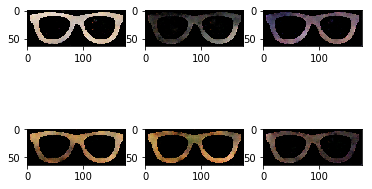

/home/tva/.local/lib/python3.5/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


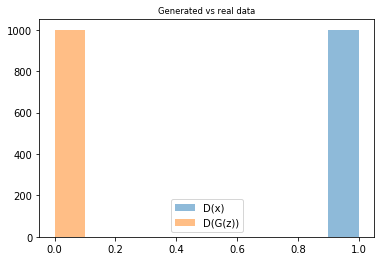

d loss 0.0004247135657351464
attack success 0
loss f tensor(-60., device='cuda:0', grad_fn=<SubBackward0>)
g loss 29.99992561340332
d loss 0.0015013362281024456
attack success 0
loss f tensor(-60., device='cuda:0', grad_fn=<SubBackward0>)
g loss 29.999584197998047
d loss 0.0037183729000389576
attack success 0
loss f tensor(-60., device='cuda:0', grad_fn=<SubBackward0>)
g loss 29.999128341674805
d loss 0.009470060467720032
attack success 0
loss f tensor(-60., device='cuda:0', grad_fn=<SubBackward0>)
g loss 29.996801376342773
d loss 0.009731544181704521
attack success 0
loss f tensor(-60., device='cuda:0', grad_fn=<SubBackward0>)
g loss 29.996171951293945
d loss 0.04943949356675148
attack success 0
loss f tensor(-60., device='cuda:0', grad_fn=<SubBackward0>)
g loss 29.998191833496094
d loss 0.003898516297340393
attack success 0
loss f tensor(-60., device='cuda:0', grad_fn=<SubBackward0>)
g loss 29.9947452545166
d loss 0.011948113329708576
attack success 0
loss f tensor(-60., device='cuda

In [ ]:
from IPython import display
from tqdm import tnrange
batch_size = 60

for epoch in tnrange(50000):
    
    # Train discriminator
    for i in range(1):
        real_data = sample_data_batch(batch_size)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data, discriminator=discriminator)
        print('d loss', loss.item())
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()
        
    # Train generator
    for i in range(1):
        noise = sample_noise_batch(batch_size)
        
        generated_glasses = generator(noise).cpu()#.numpy().transpose((0, 2, 3, 1)) * 128. + 128
        faces = torch.from_numpy(get_faces(batch_size,face_dataset, [19]).transpose(0, 3, 1, 2)) #/ 255.
#         print(faces[0].max(), generated_glasses[0].max())
        aligned_faces = align_data_glasses(imgs_batch=faces, glasses_batch=generated_glasses, cropped_glasses=True)
#         print(aligned_faces.)
        loss_f = dodge_fr_loss(aligned_faces, 19)
        gc.collect()
        print('loss f', loss_f)
#         plt.imshow(aligned_faces[0].detach().cpu().numpy().transpose((1,2,0)))
#         plt.show()
        
        loss = generator_loss(noise, discriminator=discriminator, generator=generator) - 0.5 * loss_f
        print('g loss', loss.item())
        gen_opt.zero_grad()
        loss.backward()
        gen_opt.step()

        
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2, 3, generator, True)
        sample_probas(1000)
        

In [ ]:
from datetime import datetime
mrk = datetime.now().strftime('%d_%h__%H_%M')
torch.save(generator.state_dict(), 'generator_' + mrk + '.pth')
torch.save(discriminator.state_dict(), 'discriminator' + mrk + '.pth')

In [ ]:
plt.figure(figsize=[16, 24])
sample_images(16, 8, generator)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better